In [ ]:
#Visual notebook for get data workflow 4

In [1]:
#Imports
import matplotlib.pyplot as plt
import pandas as pd
import pdb

In [2]:
#Initial grouping of files
#Functions
def read_tsv(H_groups_file):
	'''Read ids and H-groups into dict
	'''

	H_groups = {} #Store H-groups and uids

	with open(H_groups_file) as file:
		for line in file:
			line = line.rstrip() #remove \n
			line = line.split(',')
			uid = line[0]
			H_group = line[1:]
			H_group = H_group[0]+'.'+H_group[1]+'.'+H_group[2]+'.'+H_group[3]
			H_groups[uid] = H_group


	return H_groups

def read_fasta(fasta_file):
	'''Read fasta file into dict
	'''

	sequences = {} #Store sequences

	with open(fasta_file) as file:
		for line in file:
			line = line.rstrip() #remove \n
			if line[0] == '>':
				uid = line.split('|')[2].split('/')[0]
			else:
				sequences[uid] = line

	return sequences


def get_groups(H_groups, sequences):
	'''Get H-group for each uid and group sequences accordingly
	'''


	grouped_sequences = {} #Sequences grouped by H-group

	for key in sequences:
		H_group = H_groups[key]
		sequence = sequences[key]

		if H_group not in grouped_sequences.keys(): #If not in new dict - add
			grouped_sequences[H_group] = [key + '/' + sequence]
		else:
			grouped_sequences[H_group].append(key + '/' + sequence) #Otherwise append

	return grouped_sequences



H_groups = read_tsv('/home/pbryant/data/CATH/h_grouped/H_group.tsv')
sequences = read_fasta('/home/pbryant/data/CATH/reallybelow95.fa')
grouped_sequences = get_groups(H_groups, sequences)

Text(0.5, 1.0, 'At least 2 entries\nTotal number of entries: 51452\nTotal number of groups: 3183')

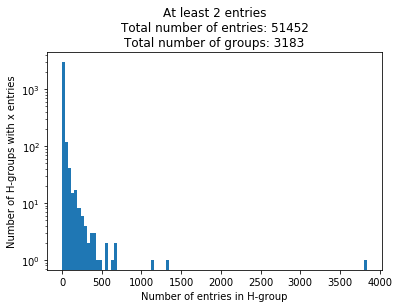

In [3]:
num_entries = []
over_x = []
x = 2
for key in grouped_sequences:
    num_entries.append(len(grouped_sequences[key]))
    if len(grouped_sequences[key]) >= x:
        over_x.append(len(grouped_sequences[key]))
plt.hist(over_x, bins = 100, log = True)
plt.xlabel('Number of entries in H-group')
plt.ylabel('Number of H-groups with x entries')
average = sum(over_x)/len(over_x)
plt.title('At least 2 entries\n'+'Total number of entries: '+str(sum(over_x)) + '\n' +'Total number of groups: ' + str(len(over_x)))

In [3]:
failed_pdb_filter = pd.read_csv('/home/pbryant/data/CATH/failed_pdb_filter_2.6Å.txt', sep = '\n', header = None)
u_hgroups = []
for row in failed_pdb_filter[0]:
    group = H_groups[row]
    if group in u_hgroups:
        continue
    else:
        u_hgroups.append(group)
print('Failed groups:',len(u_hgroups), '|Failed uids:',len(failed_pdb_filter))
#Should count how many groups disappear by removing the uids that failed

Failed groups: 2984 |Failed uids: 25446


In [5]:
failed_uids = [*failed_pdb_filter[0]]
passed_uids = []
for uid in sequences:
    if uid in failed_uids:
        continue
    else:
        passed_uids.append(uid)
    
    

In [9]:
passed_uids[0:10]
H_groups['12asA00']

'3.30.930.10'

In [6]:
H_groups = read_tsv('/home/pbryant/data/CATH/h_grouped/H_group.tsv')
passed_uids_grouped = {} #Sequences grouped by H-group
for uid in passed_uids:
    H_group = H_groups[uid]
       
    if H_group not in passed_uids_grouped.keys(): #If not in new dict - add
        passed_uids_grouped[H_group] = [uid]
    else:
        passed_uids_grouped[H_group].append(uid) #Otherwise append


Text(0.5, 1.0, 'At least 2 entries\nTotal number of entries: 39211\nTotal number of groups: 2489')

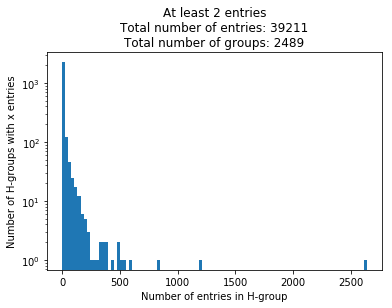

In [9]:
num_entries = []
over_x = []
x = 2
for key in passed_uids_grouped:
    num_uids = len(passed_uids_grouped[key])
    num_entries.append(num_uids)
    if num_uids >= x:
        over_x.append(num_uids)
plt.hist(over_x, bins = 100, log = True)
plt.xlabel('Number of entries in H-group')
plt.ylabel('Number of H-groups with x entries')
average = sum(over_x)/len(over_x)
plt.title('At least 2 entries\n'+'Total number of entries: '+str(sum(over_x)) + '\n' +'Total number of groups: ' + str(len(over_x)))